In [ ]:
import torch
import sys
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Experiment configuration
data_augmentation = True
batch_size_var = 512
batch_norm_var = True
l2 = False
scheduler_bool = False
early_stop = False


# number of steps for early stopping
early_stop_thresh = 3
# number of epochs
num_epochs = 100

In [ ]:
device

device(type='cpu')

# Data augmentation

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Data Loading

In [ ]:
trainset = datasets.CIFAR10(root='~/.pytorch/CIFAR10', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='~/.pytorch/CIFAR10', train=False, transform=transform)

train_loader = DataLoader(trainset, batch_size=batch_size_var, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size_var, shuffle=False)


Files already downloaded and verified


# Data augmentation transformation

In [ ]:
augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Create a new dataset with augmented images

In [ ]:
augmented_dataset = datasets.CIFAR10(root='~/.pytorch/CIFAR10', train=True, download=True, transform=augmentation_transform)

# Concatenate the original trainset with the augmented dataset
combined_trainset = ConcatDataset([trainset, augmented_dataset])

# Create DataLoader for the combined training set only if we want it
if data_augmentation:
    train_loader = DataLoader(combined_trainset, batch_size=batch_size_var, shuffle=True)
    print("Using data augmentation")
else:
    print("No data augmentation")

Files already downloaded and verified
Using data augmentation


In [ ]:
for images, labels in train_loader:
    print(images.size(), labels.size())
    break

torch.Size([512, 3, 32, 32]) torch.Size([512])


In [ ]:
# Compare sizes of the original trainset and the augmented combined trainset
original_trainset_size = len(trainset)
augmented_trainset_size = len(augmented_dataset)
combined_trainset_size = len(combined_trainset)

print(f"Original Trainset Size: {original_trainset_size}")
print(f"Augmented Trainset Size: {augmented_trainset_size}")
print(f"Combined Trainset Size: {combined_trainset_size}")

Original Trainset Size: 50000
Augmented Trainset Size: 50000
Combined Trainset Size: 100000


In [ ]:
# Get a batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Transformation for visualization (undo normalization)
inv_normalize = transforms.Normalize(
    mean=[-mean[0] / std[0], -mean[1] / std[1], -mean[2] / std[2]],
    std=[1 / std[0], 1 / std[1], 1 / std[2]]
)


In [ ]:
# Function to display an image
def show_image(img, title):
    img = inv_normalize(img)
    img = torch.clamp(img, 0, 1)  # Clip values to stay within the valid range
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

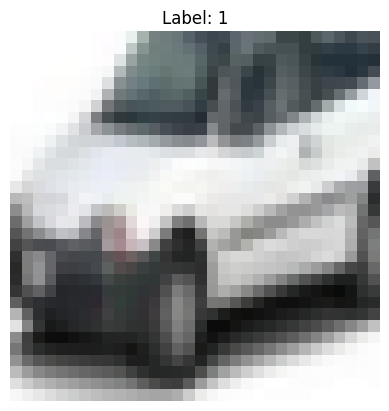

In [ ]:
# Display the first image from the batch
show_image(images[0], title=f"Label: {labels[0]}")

# Model design

In [ ]:
class CustomCNNCifar(nn.Module):
    def __init__(self, num_classes=10, batch_norm=True):
        super(CustomCNNCifar, self).__init__()
        self.batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        # 16x16x8
        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(8)
        self.relu1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        # 8x8x16
        if self.batch_norm:
            self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        # 4x4x32
        if self.batch_norm:
            self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.LeakyReLU()

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        # 2x2x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 1x1x64
        if self.batch_norm:
            self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.LeakyReLU()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64, num_classes)

        self.log_softmax = nn.LogSoftmax(dim=1)  # Softmax activation for classification

    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        if self.batch_norm:
            x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        if self.batch_norm:
            x = self.bn4(x)
        x = self.pool1(x)
        x = self.relu4(x)

        x = self.flatten(x)

        x = self.fc1(x)

        x = self.log_softmax(x)  # Apply softmax for classification
        return x

# Create an instance of the SimpleCNNReduced model

In [ ]:
model = CustomCNNCifar(num_classes=10, batch_norm=batch_norm_var)
if batch_norm_var:
    print("Using batch norm")

Using batch norm


In [ ]:
# Calculate the total number of trainable parameters
total_params_reduced = count_parameters(model)
print(f"Total trainable parameters in the reduced model: {total_params_reduced}")

Total trainable parameters in the reduced model: 25418


In [ ]:
print(model.to(device))

CustomCNNCifar(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.01)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_featu

In [ ]:
model = CustomCNNCifar(num_classes=10, batch_norm=batch_norm_var)
model = model.to(device)
if l2:
  optimizer = Adam(model.parameters(), weight_decay=1e-5)  # L2 regularization
else:
  optimizer = Adam(model.parameters())
if scheduler_bool:
  scheduler = StepLR(optimizer, step_size=30, gamma=0.1)  # Learning rate schedule
criterion = nn.NLLLoss()

In [ ]:
cum_epoch_loss = 0
best_val = sys.maxsize
start_time = time.time()
best_val_e = sys.maxsize
best_epoch = 0

# Initialize lists to track training and validation metrics
train_losses = []
val_losses = []
val_accuracies = []

# Training loop for each epoch
for e in range(num_epochs):
    batch_loss = 0

    # Training phase
    model.train()
    for batch, (inputs, outputs) in enumerate(train_loader, 1):
        inputs = inputs.to(device)
        outputs = outputs.to(device)
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, outputs)
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()

    # Calculate and store average training loss for the epoch
    average_train_loss = batch_loss / len(train_loader)
    train_losses.append(average_train_loss)

    print(f'Epoch({e + 1}/{num_epochs})')
    print(f'Training loss: {average_train_loss}')

    # Validation phase
    model.eval()
    val_loss = 0
    num_correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch_val, (inputs, outputs) in enumerate(test_loader, 1):
            inputs = inputs.to(device)
            outputs = outputs.to(device)

            predictions = model(inputs)
            loss = criterion(predictions, outputs)

            val_loss += loss.item()

            # Calculate validation accuracy
            output_probs = torch.exp(predictions)
            pred = torch.argmax(output_probs, 1)
            total_val += outputs.size(0)
            num_correct_val += (pred == outputs).sum().item()

        # Calculate and store average validation loss for the epoch
        average_val_loss = val_loss / len(test_loader)
        val_losses.append(average_val_loss)

        # Calculate and store validation accuracy for the epoch
        val_accuracy = num_correct_val * 100 / total_val
        val_accuracies.append(val_accuracy)

        print(f'Validation loss: {average_val_loss}')
        print(f'Validation accuracy: {val_accuracy}%')

        # Best model checkpointing
        if average_val_loss < best_val:
            print(f'Checkpointing new best model in epoch {e + 1}')
            checkpoint(model, "best_model.pkl")
            best_val = average_val_loss

    # Check val loss of epoch for early stopping
    if average_val_loss < best_val_e:
        best_val_e = average_val_loss
        best_epoch = e

    # Early stopping
    if early_stop:
      if e - best_epoch > early_stop_thresh:
          print(f'Early stopped training at epoch {e + 1}')
          break  # Terminate the training loop

    if scheduler_bool:
      scheduler.step()  # Step the learning rate scheduler

print(f'\nFinal, best val error: {best_val}')

end_time = time.time()
elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Elapsed Time: {minutes} minutes and {seconds} seconds")

Epoch(1/100)
Training loss: 1.74088888569754
Validation loss: 1.4149277687072754
Validation accuracy: 49.2%
Checkpointing new best model in epoch 1
Epoch(2/100)
Training loss: 1.4913385157682457
Validation loss: 1.2917672872543335
Validation accuracy: 54.11%
Checkpointing new best model in epoch 2
Epoch(3/100)
Training loss: 1.4117554882351233
Validation loss: 1.2290728032588958
Validation accuracy: 56.3%
Checkpointing new best model in epoch 3
Epoch(4/100)
Training loss: 1.3591094935426906
Validation loss: 1.1962761759757996
Validation accuracy: 57.58%
Checkpointing new best model in epoch 4
Epoch(5/100)
Training loss: 1.3169570492238414
Validation loss: 1.1610973477363586
Validation accuracy: 58.65%
Checkpointing new best model in epoch 5
Epoch(6/100)
Training loss: 1.2829151561065597
Validation loss: 1.1275700271129607
Validation accuracy: 60.26%
Checkpointing new best model in epoch 6
Epoch(7/100)
Training loss: 1.2586973887317034
Validation loss: 1.0988141477108002
Validation accu

In [ ]:
model.eval()
with torch.no_grad():
    num_correct = 0
    total = 0

    for batch, (images, labels) in enumerate(test_loader, 1):
        images = images.to(device)  # Move images to the same device as the model
        labels = labels.to(device)

        logps = model(images)
        output = torch.exp(logps)

        pred = torch.argmax(output, 1)
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()

    print(f'Accuracy of the model on {total} test images: {num_correct * 100 / total}% ')

Accuracy of the model on 10000 test images: 69.06% 


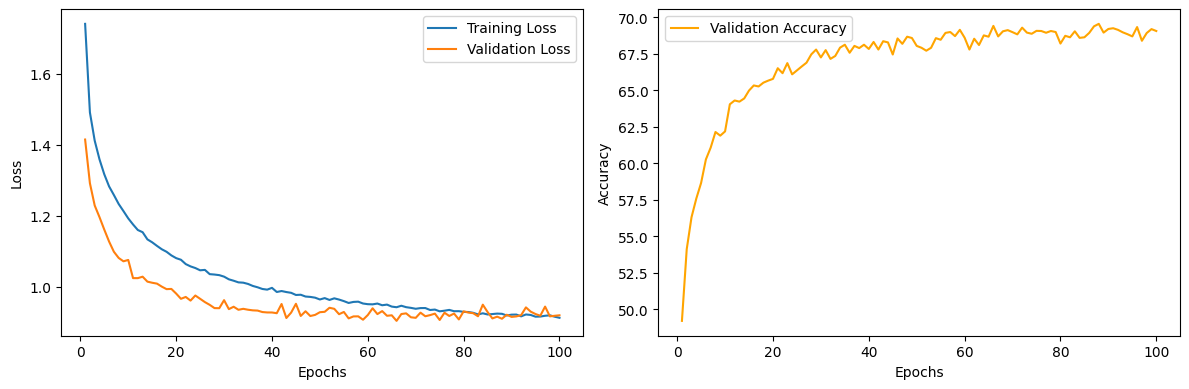

In [ ]:
# After training
plt.figure(figsize=(12, 4))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, e + 2), train_losses, label='Training Loss')
plt.plot(range(1, e + 2), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, e + 2), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()